In [150]:
# TODO: Task 1 Train SVC ( SVR )
# TODO: 1. kernel = 'linear', diff values for C
# TODO: 2. kernel = 'rbf', diff values for C and gamma
# TODO: 3. Understand difference between linear and rbf kernel

In [151]:
 # TODO: Task 2 Change GridSearchCV to RandomizedSearchCV

In [152]:
# TODO: Task 3 add to pipeline Feature extraction and selection

In [153]:
# TODO: Task 4 Create full pipeline with all steps

In [154]:
# TODO: Solution -> https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb

In [2]:
from sklearn.svm import SVR # use Regression version of SVC
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction import DictVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

In [18]:
data = fetch_california_housing(as_frame=True)

In [24]:
X = data.data
y = data.target

In [25]:
# let's use IQR to adjust outliers
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
for col in X.columns:
    X.loc[X[col] > upper_bound, col] = upper_bound
    X.loc[X[col] < lower_bound, col] = lower_bound

/tmp/ipykernel_4079/3150774754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X[col] > upper_bound, col] = upper_bound
/tmp/ipykernel_4079/3150774754.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X[col] < lower_bound, col] = lower_bound


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X.shape, y.shape

((20640, 8), (20640,))

In [28]:
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, X.columns)
    ])

In [29]:
transformer = Pipeline(steps=[
        ('preprocessor', preprocessor),
])

In [30]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [31]:
# TODO: 1. kernel = 'linear', diff values for C
linear_kernel_svc = SVR(kernel='linear')
# param_grid_linear = {
#     'svr__C': [0.01, 0.1, 1, 10, 100]
# }

param_grid_linear = {
    # 'svr__C': np.logspace(-3, 3, 7)
    'svr__C': [0.01,]
}

In [32]:
pipeline = make_pipeline(transformer, linear_kernel_svc)
search_linear = RandomizedSearchCV(pipeline, param_grid_linear, cv=cv, n_iter=1, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0, return_train_score=False)

In [33]:
search_linear.fit(X_train, y_train)

,estimator,Pipeline(step...l='linear'))])
,param_distributions,{'svr__C': [0.01]}
,n_iter,1
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [34]:
best_model_linear = search_linear.best_estimator_
best_score_linear = search_linear.best_score_

In [35]:
print(f'Best Linear Kernel SVC Score: {best_score_linear:.4f}') # -0.4967

Best Linear Kernel SVC Score: -0.5935


In [36]:
print(f'Best Linear Kernel SVC Params: {search_linear.best_params_}')

Best Linear Kernel SVC Params: {'svr__C': 0.01}


In [37]:
score = cross_val_score(best_model_linear, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
print(f'Cross-validation Linear Kernel SVC scores: {score}')

Cross-validation Linear Kernel SVC scores: [-0.62029048 -0.61100396 -0.5830099  -0.56805853 -0.61521039]


In [38]:
mean = np.mean(-score)
std = np.std(-score)
print(f'Mean CV Linear Kernel SVC: {mean:.4f} +/- {std:.4f}') # Mean CV Linear Kernel SVC: 0.4867 +/- 0.0262

Mean CV Linear Kernel SVC: 0.5995 +/- 0.0204


In [39]:
some_house = X_test.iloc[:5]
some_labels = y_test.iloc[:5]
print("Predictions:", best_model_linear.predict(some_house))
print("Labels:", list(some_labels))
print(f'Errors: {list(best_model_linear.predict(some_house) - some_labels)}')

Predictions: [0.74224313 1.34442583 2.54657233 2.75912984 1.9398202 ]
Labels: [0.477, 0.458, 5.00001, 2.186, 2.78]
Errors: [0.2652431264860319, 0.8864258309269497, -2.4534376697485567, 0.5731298443605253, -0.8401798028197764]


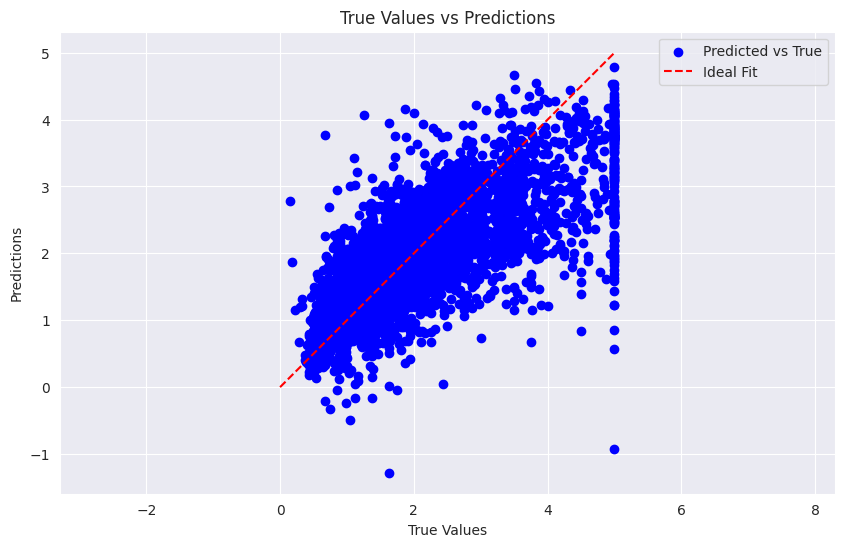

In [40]:
# let's draw plot with true labels vs predicted ( predicted must be other color )
# for predicted values must be color green, for true label must be color blue
y_test_pred = best_model_linear.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs True')
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.legend()
plt.axis('equal')
plt.xlim(-1, 6)
plt.ylim(-1, 6)
plt.grid(True)
plt.show()

In [41]:
rbf_kernel_svc = SVR(kernel='rbf')
param_grid_rbf = {
    'svr__C': [0.01, 0.1, 1, 10, 100],
    'svr__gamma': [0.001, 0.01, 0.1, 1, 10]
    }
pipeline = make_pipeline(transformer, rbf_kernel_svc)
search = RandomizedSearchCV(pipeline, param_grid_rbf, cv=cv, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0, return_train_score=False)

In [ ]:
search.fit(X_train, y_train)

In [ ]:
best_model_rbf = search.best_estimator_
best_score = search.best_score_

In [ ]:
print(f'Best RBF Kernel SVC Score: {best_score:.4f}') #

In [ ]:
score = cross_val_score(best_model_rbf, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
print(f'Cross-validation Linear Kernel SVC scores: {score}')

In [ ]:
mean = np.mean(-score)
std = np.std(-score)
print(f'Mean CV Linear Kernel SVC: {mean:.4f} +/- {std:.4f}') # Mean CV RBF Kernel SVC: 0.4867 +/- 0.0262

In [ ]:
some_house = X_test.iloc[:5]
some_labels = y_test.iloc[:5]
print("Predictions:", best_model_rbf.predict(some_house))
print("Labels:", list(some_labels))
print(f'Errors: {list(best_model_rbf.predict(some_house) - some_labels)}')

In [ ]:
# let's draw plot with true labels vs predicted ( predicted must be other color )
# for predicted values must be color green, for true label must be color blue
y_test_pred = best_model_rbf.predict(X_test)
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs True')
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()